The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
x0 =  1.9296296834945679


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.51it/s]


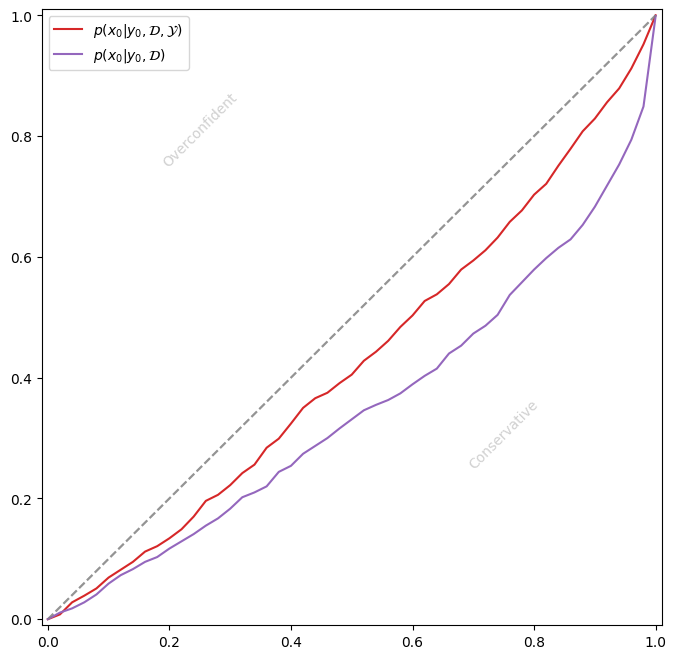

In [81]:
from misc import * 
import torch
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from regressor import *
from utils import *
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

scale_sigma2 = torch.tensor(.5)
shape_sigma2 = torch.tensor(.5)
sigma20 = pyro.distributions.InverseGamma(shape_sigma2, scale_sigma2).sample()
sigma20 = torch.tensor(1)

mu_beta = torch.zeros(2)
Sigma_beta = torch.eye(2)
alpha = torch.tensor([1.,0.])

mu_X =torch.tensor(3.)
sigma2_X =torch.tensor(1.)
inference_prior = torch.distributions.Normal(mu_X, torch.sqrt(sigma2_X))
x0 = inference_prior.sample()

prior_dataset = torch.distributions.Normal(torch.tensor(3.), torch.tensor(1))
n_D = 2
DX =prior_dataset.sample([n_D])
range_unif = 8

sigma2_simulateur = torch.tensor(1)
f = lambda x: beta0[0]*x + beta0[1] 
simulateur= lambda x: f(x) + torch.randn(x.shape[0])*torch.sqrt(sigma20)
DY = simulateur(DX)

print('x0 = ',str(x0.item()))
n_y0= 1
y0 = simulateur(x0.repeat(n_y0))


posterior_mean, posterior_sigma2 =generative_bayesian_linear_regression_known_variance(sigma20,mu_X, sigma2_X).compute_x0_given_y0_beta_moments(y0, torch.tensor(1.))
posterior = torch.distributions.Normal(posterior_mean, torch.sqrt(posterior_sigma2))


mu_xj = torch.tensor(-4.)
sigma2_xj = torch.tensor(.5)
prior_unlabeled = torch.distributions.Normal(mu_xj, torch.sqrt(sigma2_xj))
list_xj = []
list_yj = []
n_unlabeled_obs = 50
n_per_obs = 1
for t in range(n_unlabeled_obs):
    xj = prior_unlabeled.sample()
    list_xj.append(xj.unsqueeze(0).repeat(n_per_obs))
    yj = simulateur(xj.unsqueeze(0).repeat(n_per_obs))
    list_yj.append(yj.unsqueeze(0))
if n_unlabeled_obs>0:
    Y = torch.cat(list_yj, dim = 0)
    X = torch.cat(list_xj, dim = 0)
else: 
    Y = torch.tensor([])
    X = torch.tensor([])
prior_means = mu_xj*torch.ones(n_unlabeled_obs)
prior_sigma2s = sigma2_xj*torch.ones(n_unlabeled_obs)

y_min = torch.min(torch.cat([DY, torch.flatten(Y), y0])-2)
y_max = torch.max(torch.cat([DY, torch.flatten(Y), y0])+2)
x_min = torch.min(torch.cat([DX, torch.flatten(X), x0.unsqueeze(-1)])-2)
x_max = torch.max(torch.cat([DX, torch.flatten(X), x0.unsqueeze(-1)])+2)

def plot_expected_coverage_1d_from_density(log_prob,window, tested_samples, label = None, show =False, color = None):
    assert tested_samples.shape[-1] == 1,'Dimension >= 1 not supported'
    to_plot, window = compute_expected_coverage_from_density(log_prob,window, tested_samples)
    plt.plot(window.numpy(), to_plot.numpy(), label = label, color = color)
    plt.plot(window.numpy(),window.numpy(), linestyle = '--', color = 'grey', alpha =.6)
    plt.text(.25,.75, 'Overconfident', rotation = 45, color = 'grey', alpha = .2, ha = 'center')
    plt.text(.75,.25, 'Conservative', rotation=45, color='grey', alpha=.2,ha = 'center')
    if show:
        plt.show()

blr = generative_bayesian_affine_regression(mu_X, sigma2_X, mu_beta,Sigma_beta,shape_sigma2, scale_sigma2)
X0g,_,_ = blr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY,number_steps=1000, verbose = True)
X0gssl,_,_ = blr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, Y,prior_means, prior_sigma2s, number_steps=1000, verbose = True)
plt.figure(figsize = (8,8))
ax = plt.subplot()
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
plot_expected_coverage_1d_from_density(posterior.log_prob,[-20,40], X0gssl.unsqueeze(-1), show=False, color = 'C3',label = r'$p(x_0|y_0,\mathcal{D},\mathcal{Y})$')
plot_expected_coverage_1d_from_density(posterior.log_prob,[-20,40], X0g.unsqueeze(-1), show=False, color = 'C4', label= r'$p(x_0|y_0,\mathcal{D})$')
plt.legend()
plt.show()

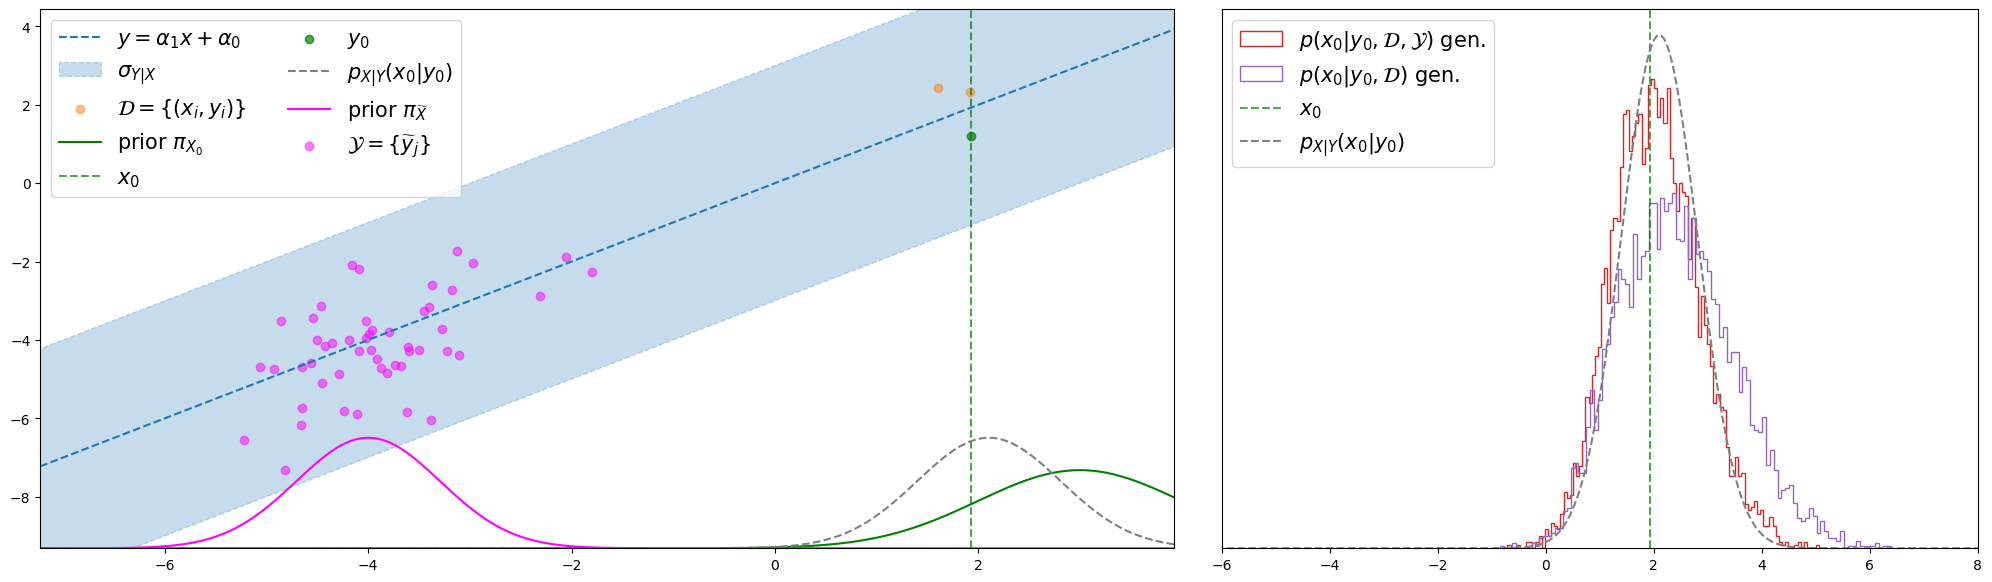

In [72]:
fig = plt.figure(figsize = (25,7))
ax = fig.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, squeeze = True)
tt = torch.linspace(x_min,x_max,300)
ax[0].set_xlim(x_min,x_max)
ax[0].plot(tt.numpy(),(alpha[0]*tt+ alpha[1]).numpy(), linestyle = '--', label = r'$y = \alpha_1x+ \alpha_0$', color ='C0')
ax[0].fill_between(tt.numpy(),(alpha[0]*tt+ alpha[1]).numpy() - 3*torch.sqrt(sigma20).numpy(),(alpha[0]*tt+ alpha[1]).numpy() + 3*torch.sqrt(sigma20).numpy(),linestyle = '--',color = 'C0',alpha = 0.25, label = r'$\sigma_{Y|X}$')
ax[0].scatter(DX.numpy(), DY.numpy(), alpha =.5, label = r'$\mathcal{D}=\{(x_i,y_i)\}$', color = 'C1')
ax[0].plot(tt, y_min + 5*torch.exp(inference_prior.log_prob(tt.unsqueeze(-1))), color = 'green', label=r'prior $\pi_{X_0}$')
ax[0].axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
ax[0].scatter(x0.repeat(n_y0), y0, color = 'green', alpha = .7, label = r'$y_0$')
ax[0].plot(tt,y_min+5*torch.exp(posterior.log_prob(tt)),linestyle ='--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
ax[0].plot(tt, y_min + 5*torch.exp(prior_unlabeled.log_prob(tt.unsqueeze(-1))), color = 'magenta', label=r'prior $\pi_{\widetilde{X}}$')
ax[0].scatter(X,Y,color = 'magenta', alpha = .5, label = r'$\mathcal{Y} = \{\widetilde{y}_j\}$')
ax[0].set_ylim(y_min,y_max)
ax[0].legend(ncol = 2, fontsize = 15,loc = 'upper left')

tt = torch.linspace(2, 12, 300)
ax[1].hist(X0gssl, bins = 100, density = True, histtype = 'step', label = r'$p(x_0|y_0,\mathcal{D},\mathcal{Y})$ gen.', color = 'C3')
ax[1].hist(X0g, bins = 100, density = True, histtype = 'step', label= r'$p(x_0|y_0,\mathcal{D})$ gen.', color = 'C4')
ax[1].axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
ax[1].plot(tt_post, torch.exp(posterior.log_prob(tt_post)),linestyle = '--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
ax[1].tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
ax[1].legend(ncol = 1, fontsize = 15,loc = 'upper left')
ax[1].set_xlim(-4,7)
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [04:13<00:00, 197.46it/s]


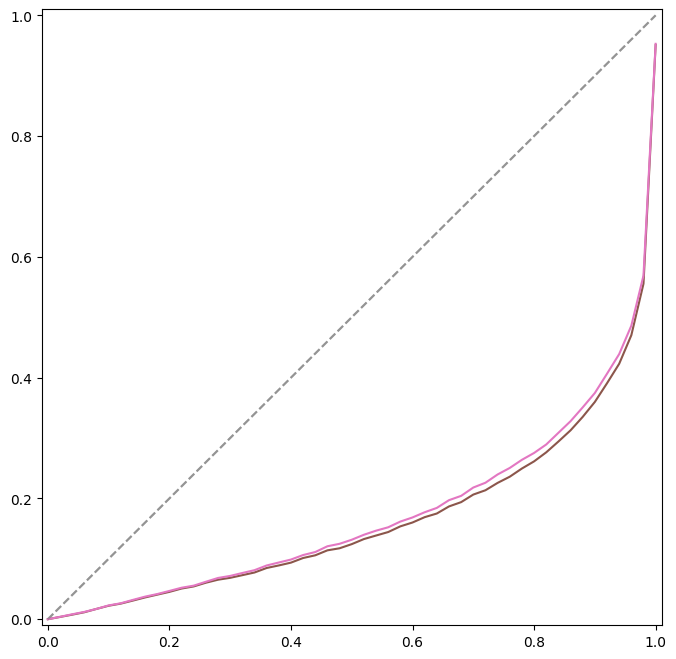

In [73]:
dlbr = discriminative_bayesian_affine_regression(mu_beta, Sigma_beta, shape_sigma2, scale_sigma2)
X0d,_,_ = dlbr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, number_steps = 50000, verbose = True)
X0dssl,_,_ = dlbr.sample_x0_given_y0_D_Y_gibbs(y0, DX, DY, Y, number_steps = 50000, verbose = True)
plt.figure(figsize = (8,8))
ax = plt.subplot()
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)
plot_expected_coverage_1d_from_density(true_posterior.log_prob,[-20,40], X0d.unsqueeze(-1), show=False, color ='C5', label = r'$p(x_0|y_0,\mathcal{D})$')
plot_expected_coverage_1d_from_density(true_posterior.log_prob,[-20,40], X0dssl.unsqueeze(-1), show=False, color='C6', label= r'$p(x_0|y_0,\mathcal{D})$')
plt.show()

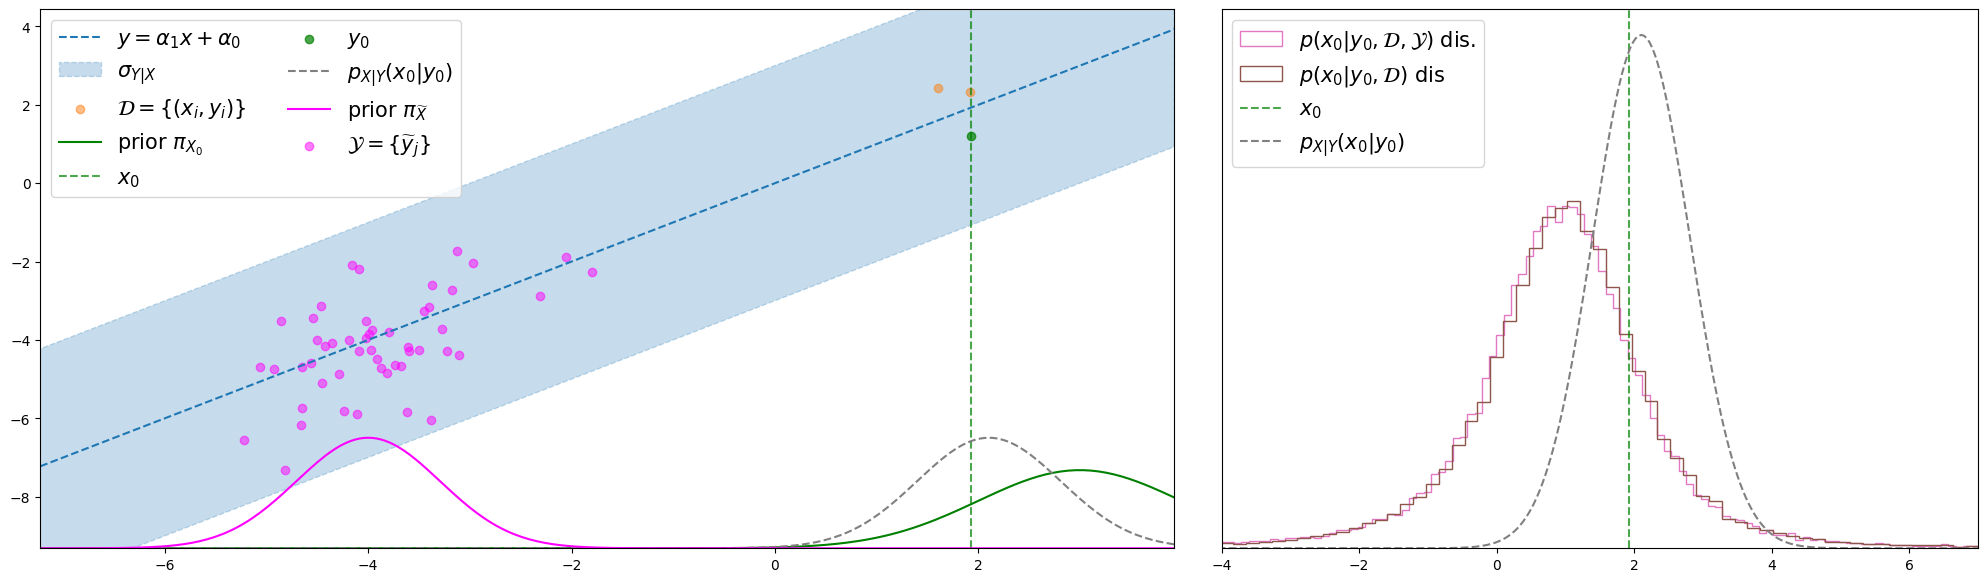

In [76]:
fig = plt.figure(figsize = (25,7))
ax = fig.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]}, squeeze = True)
tt = torch.linspace(x_min,x_max,300)
ax[0].set_xlim(x_min,x_max)
ax[0].plot(tt.numpy(),(alpha[0]*tt+ alpha[1]).numpy(), linestyle = '--', label = r'$y = \alpha_1x+ \alpha_0$', color ='C0')
ax[0].fill_between(tt.numpy(),(alpha[0]*tt+ alpha[1]).numpy() - 3*torch.sqrt(sigma20).numpy(),(alpha[0]*tt+ alpha[1]).numpy() + 3*torch.sqrt(sigma20).numpy(),linestyle = '--',color = 'C0',alpha = 0.25, label = r'$\sigma_{Y|X}$')
ax[0].scatter(DX.numpy(), DY.numpy(), alpha =.5, label = r'$\mathcal{D}=\{(x_i,y_i)\}$', color = 'C1')
ax[0].plot(tt, y_min + 5*torch.exp(inference_prior.log_prob(tt.unsqueeze(-1))), color = 'green', label=r'prior $\pi_{X_0}$')
ax[0].axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
ax[0].scatter(x0.repeat(n_y0), y0, color = 'green', alpha = .7, label = r'$y_0$')
ax[0].plot(tt,y_min+5*torch.exp(posterior.log_prob(tt)),linestyle ='--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
ax[0].plot(tt, y_min + 5*torch.exp(prior_unlabeled.log_prob(tt.unsqueeze(-1))), color = 'magenta', label=r'prior $\pi_{\widetilde{X}}$')
ax[0].scatter(X,Y,color = 'magenta', alpha = .5, label = r'$\mathcal{Y} = \{\widetilde{y}_j\}$')
ax[0].set_ylim(y_min,y_max)
ax[0].legend(ncol = 2, fontsize = 15,loc = 'upper left')

tt = torch.linspace(2, 12, 300)
ax[1].hist(X0dssl, bins = 500, density = True, histtype = 'step', label = r'$p(x_0|y_0,\mathcal{D},\mathcal{Y})$ dis.', color = 'C6')
ax[1].hist(X0d, bins = 500, density = True, histtype = 'step', label= r'$p(x_0|y_0,\mathcal{D})$ dis', color = 'C5')
ax[1].axvline(x0.numpy(), color = 'green', alpha = .7, linestyle = '--', label='$x_0$')
ax[1].plot(tt_post, torch.exp(posterior.log_prob(tt_post)),linestyle = '--', label = r'$p_{X|Y}(x_0|y_0)$', color = 'grey')
ax[1].tick_params(left=False,bottom=True,labelleft=False,labelbottom=True)
ax[1].legend(ncol = 1, fontsize = 15,loc = 'upper left')
ax[1].set_xlim(-4,7)
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()